# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import make_column_transformer
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector
from sklearn.ensemble import RandomForestRegressor

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [3]:
PATH = "./data/"

In [4]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [5]:
pd.set_option('display.max_rows', 5000)
data.head(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [6]:
male_count, female_count = data[data['Sex'] == 'male'].shape[0], data[data['Sex'] == 'female'].shape[0]
male_survived_count, female_survived_count = data[data['Sex'] == 'male']['Survived'].sum(), data[data['Sex'] == 'female']['Survived'].sum()
total_count, total_survived_count = male_count + female_count, male_survived_count + female_survived_count

In [7]:
print('\ttotal\tsurvived %total\t%in survived\t%of survived')
print(f'males\t{male_count}\t{male_survived_count}\t {100*male_count/total_count:.2f}\t{100*male_survived_count/total_survived_count:.2f}\t\t{100*male_survived_count/male_count:.2f}')
print(f'females\t{female_count}\t{female_survived_count}\t {100*female_count/total_count:.2f}\t{100*female_survived_count/total_survived_count:.2f}\t\t{100*female_survived_count/female_count:.2f}')
print(f'both\t{total_count}\t{total_survived_count}\t\t\t\t{100*total_survived_count/total_count:.2f}')

	total	survived %total	%in survived	%of survived
males	577	109	 64.76	31.87		18.89
females	314	233	 35.24	68.13		74.20
both	891	342				38.38


# Conclusion:
>Females tend to survive much better than men when being rescued by men who in exchange die alot.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

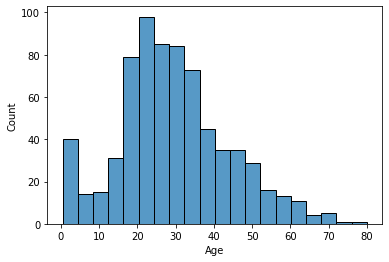

In [8]:
# age distribution of the passengers
sns.histplot(data['Age'], bins = 20);

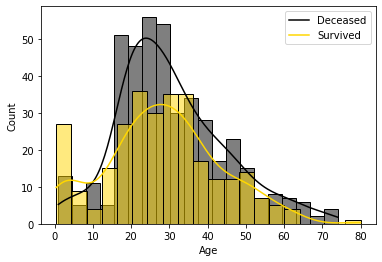

In [9]:
# age distributions for survived and deceased passengers
plt.figure()
sns.histplot(data[data['Survived'] == 0]['Age'], bins = 20, color = 'black', kde = True)
sns.histplot(data[data['Survived'] > 0]['Age'], bins = 20, color = 'gold', kde = True)
plt.legend(labels = ['Deceased', 'Survived'])
plt.show()

In [10]:
survived_age_mean = data.loc[data['Survived'] == 1]['Age'].mean()
survived_age_median = data.loc[data['Survived'] == 1]['Age'].median()
deceased_age_mean = data.loc[data['Survived'] == 0]['Age'].mean()
deceased_age_median = data.loc[data['Survived'] == 0]['Age'].median()
print(tabulate([['survived', survived_age_mean, survived_age_median], ['deceased', deceased_age_mean, deceased_age_median]], headers = ['category', 'mean', 'median']))

category       mean    median
----------  -------  --------
survived    28.3437        28
deceased    30.6262        28


# Conclusion
> Mean and median ages of survived and deceased are almost same but it's still obvious that younger tend to survive.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

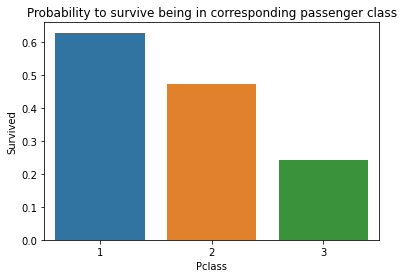

In [11]:
survival_by_class = data.groupby('Pclass')['Survived'].mean()

plt.title('Probability to survive being in corresponding passenger class')
sns.barplot(x = survival_by_class.index, y = survival_by_class)
plt.show()

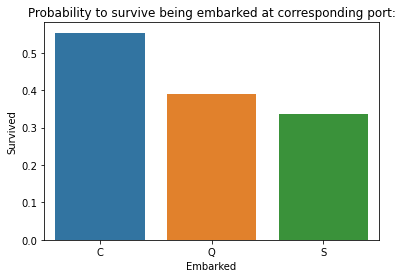

In [12]:
survival_by_port = data.groupby('Embarked')['Survived'].mean()

plt.title('Probability to survive being embarked at corresponding port:')
sns.barplot(x = survival_by_port.index, y = survival_by_port)
plt.show()

# Conclusions
> The safest class is the 1st as expected.

> People who were embarked at C port (Cherbourg) were mostly from higher classes. Historic references approve that.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [13]:
print(tabulate({k: [v] for k, v in (data.isna().mean() * 100).to_dict().items()}, headers = 'keys'))

  Survived    Pclass    Name    Sex      Age    SibSp    Parch    Ticket    Fare    Cabin    Embarked
----------  --------  ------  -----  -------  -------  -------  --------  ------  -------  ----------
         0         0       0      0  19.8653        0        0         0       0  77.1044    0.224467


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

# Conclusions
> Too many data from Cabin feature is lost and seems like there's no reliable way to restore it. We have Pclass already so barely we need Cabin for our purposes at all. Age feature is primary and 20% of loss is pretty strong. We could try to replace the missing values taking into account Pclass and Sex. More complex fix would utilize SibSp, Parch and Mr/Mrs/Miss/... part of Name as well. Embarked has lost values but the amount of loss is so low that we could just give them any of 3 values taking their distribution into account.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [14]:
pdata = data.copy()
py = pdata['Survived'].copy()

# prepare: eliminate n/a
pdata.drop(['Cabin', 'Ticket', 'Survived'], axis = 1, inplace = True)
pdata.Age.fillna(pdata.groupby(['Sex','Pclass']).transform('median').Age, inplace=True)
np.random.seed(1)
pdata['Embarked'] = pdata['Embarked'].map({ 'S': 0, 'C': 2, 'Q': 1 }).fillna(0)
pdata['Name'] = pdata['Name'].transform((lambda name:
    'Mr' if 'Mr.' in name or 'Don.' in name or 'Rev.' in name or 'Dr.' in name else
    'Officer' if 'Major.' in name or 'Capt.' in name or 'Col.' in name else
    'Noble' if 'Jonkheer.' in name or 'Sir.' in name or 'Countess.' in name else
    'Mrs' if 'Mrs.' in name or 'Lady.' in name or 'Ms.' in name else
    'Miss' if 'Miss.' in name or 'Mlle.' in name else
    'Master' if 'Master.' in name else 'Mrs'))
pdata['Sex'] = pdata['Sex'].map({ 'male': 0, 'female': 1 })
print(tabulate({ k: [v] for k, v in pdata.isna().sum().to_dict().items() }, headers = 'keys'))

  Pclass    Name    Sex    Age    SibSp    Parch    Fare    Embarked
--------  ------  -----  -----  -------  -------  ------  ----------
       0       0      0      0        0        0       0           0


In [15]:
pdata.head(1)

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,3,Mr,0,22.0,1,0,7.25,0.0


In [16]:
categorical_columns = ['Name']
numerical_columns = [ name for name in pdata.columns.to_list()
                     if name not in categorical_columns and name != 'Survived' ]

preprocessor = make_column_transformer(
    (StandardScaler(), numerical_columns),
    (OneHotEncoder(), categorical_columns))

logistic_regression_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver = 'liblinear', penalty = 'l1'))])

print(f"Accuracy of LR:  {cross_validate(logistic_regression_model, pdata, py, scoring = 'accuracy')['test_score'].mean()}")

knn_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors = 9))])

print(f"Accuracy of KNN: {cross_validate(knn_model, pdata, py, scoring = 'accuracy')['test_score'].mean()}")

Accuracy of LR:  0.8293892411022534
Accuracy of KNN: 0.8181658401858012


**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [17]:
logistic_regression_selection_model = Pipeline([
    ('preprocessor', preprocessor),
    ('polynomial', PolynomialFeatures(degree = 2)),
    ('selector', SelectFromModel(LogisticRegression(solver = 'liblinear', penalty = 'l1'))),  
    ('classifier', LogisticRegression(solver = 'liblinear', penalty = 'l1'))])

print(f"Accuracy of logistic_regression_selection_model: {cross_validate(logistic_regression_selection_model, pdata, py, scoring = 'accuracy')['test_score'].mean()}")

Accuracy of logistic_regression_selection_model: 0.8238026489234824


In [18]:
knn_selection_model = Pipeline([
    ('preprocessor', preprocessor),
    ('polynomial', PolynomialFeatures(degree = 2)),
#    ('selector', SelectFromModel(LogisticRegression(solver = 'liblinear', penalty = 'l1'))),
    ('selector', SelectFromModel(RandomForestRegressor(random_state = 1))),
    ('classifier', KNeighborsClassifier(n_neighbors = 9))])

print(f"Accuracy of knn_selection_model: {cross_validate(knn_selection_model, pdata, py, scoring = 'accuracy')['test_score'].mean()}")

Accuracy of knn_selection_model: 0.8125792480070302


Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.76 \leq score < 0.78,$$
$$ f(score) = 1.0, \ \ 0.78 \leq score < 0.81,$$ 
$$ f(score) = 2.5, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [19]:
tdata = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')

tdata.drop(['Cabin', 'Ticket'], axis = 1, inplace = True)
tdata.Age.fillna(tdata.groupby(['Sex','Pclass']).transform('median').Age, inplace=True)
tdata.fillna(0, inplace = True)
np.random.seed(1)
tdata['Embarked'] = tdata['Embarked'].map({ 'S': 0, 'C': 2, 'Q': 1 }).fillna(0)
tdata['Name'] = tdata['Name'].transform((lambda name:
    'Mr' if 'Mr.' in name or 'Don.' in name or 'Rev.' in name or 'Dr.' in name else
    'Officer' if 'Major.' in name or 'Capt.' in name or 'Col.' in name else
    'Noble' if 'Jonkheer.' in name or 'Sir.' in name or 'Countess.' in name else
    'Mrs' if 'Mrs.' in name or 'Lady.' in name or 'Ms.' in name else
    'Miss' if 'Miss.' in name or 'Mlle.' in name else
    'Master' if 'Master.' in name else 'Mrs'))
tdata['Sex'] = tdata['Sex'].map({ 'male': 0, 'female': 1 })
print('missing values:')
print(tabulate({ k: [v] for k, v in tdata.isna().sum().to_dict().items() }, headers = 'keys'))


ty = logistic_regression_model.fit(pdata, py).predict(tdata)
#ty = knn_selection_model.fit(pdata, py).predict(tdata)

pd.DataFrame({ 'PassengerId': tdata.index, 'Survived': ty }).to_csv('result.csv', index = False)
print('result saved')

missing values:
  Pclass    Name    Sex    Age    SibSp    Parch    Fare    Embarked
--------  ------  -----  -----  -------  -------  ------  ----------
       0       0      0      0        0        0       0           0
result saved


https://www.kaggle.com/sirkitter

# Conclusion
> not too bad for the 1st kaggle set

## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [20]:
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')

In [21]:
insurance_data.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [22]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [23]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [24]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [25]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [26]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

0.9631224658945812

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

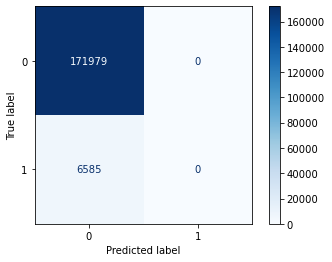

In [27]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [28]:
insurance_data.describe()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

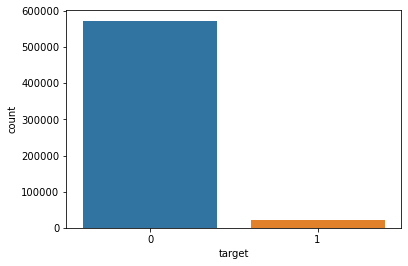

In [29]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [30]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

< your proof >

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

< your thoughts >

Let's calculate the Normalized Gini Coefficient:

In [31]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [32]:
gini_normalized(y_valid, y_pred)

0.2558723581569817

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

In [33]:
## your code